<a href="https://colab.research.google.com/github/springboardmentor789r/AgriYield/blob/Intern_MN/Times_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install catboost
!pip install prophet

In [51]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [52]:
df=pd.read_csv('crop_yield_dataset.csv')
df=df[df['Crop_Yield']!=0]

In [53]:
df.drop(columns=['Crop_Type','Soil_Type'],inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [54]:
df=df.resample('D').mean()
df

,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Date,,,,,,,,,
2014-01-01,6.250000,17.832341,79.992489,7.649061,61.285714,50.142857,40.142857,52.962570,41.714286
2014-01-02,6.928571,17.403738,79.997477,9.731096,67.285714,54.500000,43.785714,49.481053,31.964286
2014-01-03,6.250000,17.710699,78.611669,12.161914,60.785714,49.571429,40.142857,31.582386,40.601190
2014-01-04,7.125000,17.068594,79.349411,9.476664,69.375000,56.000000,44.937500,35.247034,38.703125
2014-01-05,6.375000,15.439732,80.000000,10.793227,68.062500,54.562500,43.125000,32.578187,48.994792
...,...,...,...,...,...,...,...,...,...
2023-12-27,6.406250,18.765488,79.418663,10.391741,63.687500,51.937500,41.125000,45.000561,27.786458
2023-12-28,6.583333,15.818711,79.517023,11.417404,66.000000,54.166667,42.833333,36.566595,41.680556
2023-12-29,6.843750,17.750068,79.094460,9.926405,66.062500,53.687500,42.375000,42.949637,39.281250


In [55]:
df = df.sort_index()
df

,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Date,,,,,,,,,
2014-01-01,6.250000,17.832341,79.992489,7.649061,61.285714,50.142857,40.142857,52.962570,41.714286
2014-01-02,6.928571,17.403738,79.997477,9.731096,67.285714,54.500000,43.785714,49.481053,31.964286
2014-01-03,6.250000,17.710699,78.611669,12.161914,60.785714,49.571429,40.142857,31.582386,40.601190
2014-01-04,7.125000,17.068594,79.349411,9.476664,69.375000,56.000000,44.937500,35.247034,38.703125
2014-01-05,6.375000,15.439732,80.000000,10.793227,68.062500,54.562500,43.125000,32.578187,48.994792
...,...,...,...,...,...,...,...,...,...
2023-12-27,6.406250,18.765488,79.418663,10.391741,63.687500,51.937500,41.125000,45.000561,27.786458
2023-12-28,6.583333,15.818711,79.517023,11.417404,66.000000,54.166667,42.833333,36.566595,41.680556
2023-12-29,6.843750,17.750068,79.094460,9.926405,66.062500,53.687500,42.375000,42.949637,39.281250


In [56]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

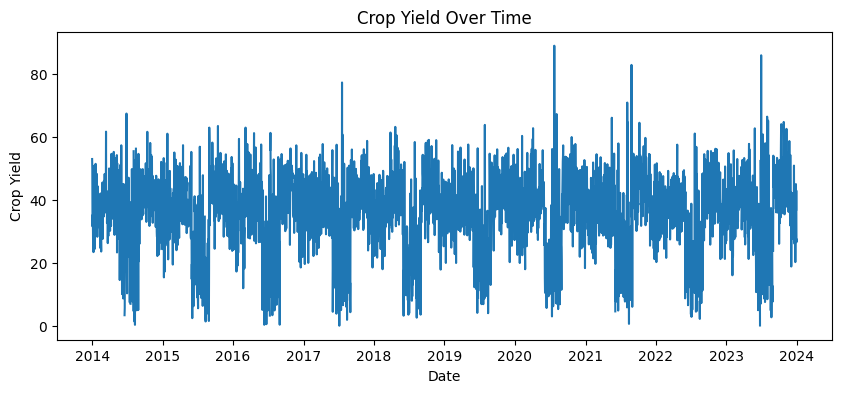

In [57]:
plt.figure(figsize=(10, 4))
plt.plot(df['Crop_Yield'])
plt.title("Crop Yield Over Time")
plt.xlabel("Date")
plt.ylabel("Crop Yield")
plt.show()

In [58]:
series=df['Crop_Yield']


In [59]:
cols=df.columns.tolist()
n=len(cols)

In [60]:
df.columns

Index(['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K',
       'Crop_Yield', 'Soil_Quality'],
      dtype='object')

In [61]:
def test_stationarity(series, col_name):
    print(f"\n--- Stationarity Test for: {col_name} ---\n")

    # 1. Plot the series
    plt.figure(figsize=(10,3))
    plt.plot(series)
    plt.title(f"{col_name} Time Series")
    plt.show()

    # 2. ACF & PACF plots
    plot_acf(series, lags=30)
    plt.title(f"ACF - {col_name}")
    plt.show()

    plot_pacf(series, lags=30)
    plt.title(f"PACF - {col_name}")
    plt.show()

    # 3. ADF Test
    adf_result = adfuller(series.dropna())
    print(adf_result)
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"ADF p-value: {adf_result[1]:.4f}")
    if adf_result[1] < 0.05:
        print("Likely Stationary\n")
    else:
        print("Likely Non-Stationary\n")

    # 4. KPSS Test
    kpss_result = kpss(series.dropna(), nlags="auto")
    print(kpss_result)
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"KPSS p-value: {kpss_result[1]:.4f}")
    if kpss_result[1] < 0.05:
        print("Likely Non-Stationary")
    else:
        print("Likely Stationary")


--- Stationarity Test for: Crop_Yield ---



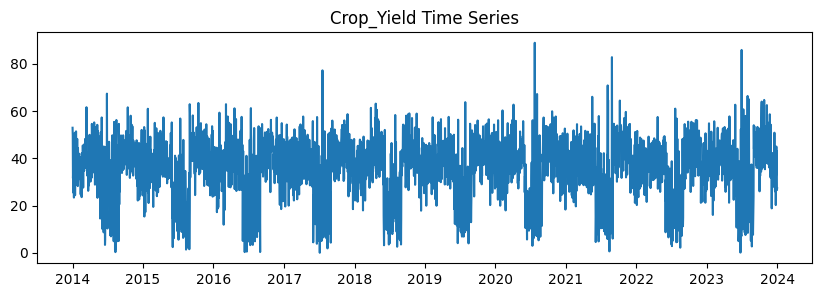

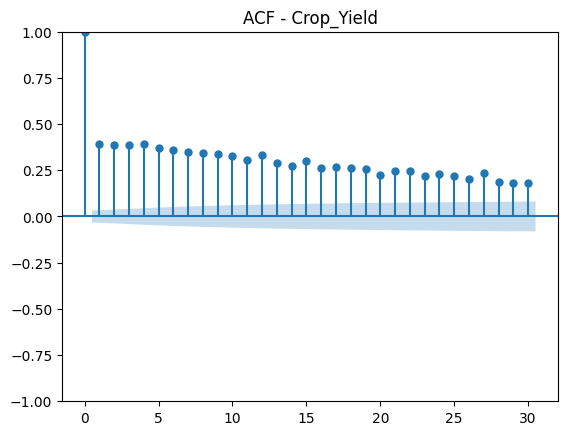

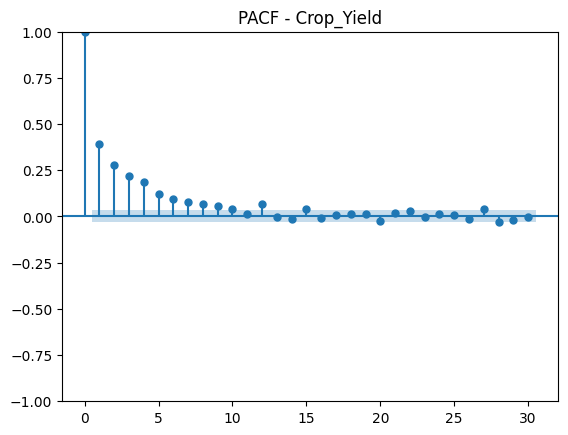

(np.float64(-7.148107107405433), np.float64(3.193310854138931e-10), 14, 3609, {'1%': np.float64(-3.4321632328202996), '5%': np.float64(-2.862341184885642), '10%': np.float64(-2.567196483328331)}, np.float64(26779.234862747777))
ADF Statistic: -7.1481
ADF p-value: 0.0000
Likely Stationary

(np.float64(0.043423677627070334), np.float64(0.1), 35, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Statistic: 0.0434
KPSS p-value: 0.1000
Likely Stationary


/tmp/ipython-input-3110577272.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), nlags="auto")


In [62]:
test_stationarity(df['Crop_Yield'].dropna(), 'Crop_Yield')


In [63]:
train_size = int(len(df['Crop_Yield']) * 0.8)
train, test = df['Crop_Yield'].iloc[:train_size], df['Crop_Yield'].iloc[train_size:]

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train, order=(1,0,1))

In [65]:
results=model.fit()

In [66]:
forecast = results.forecast(steps=20)

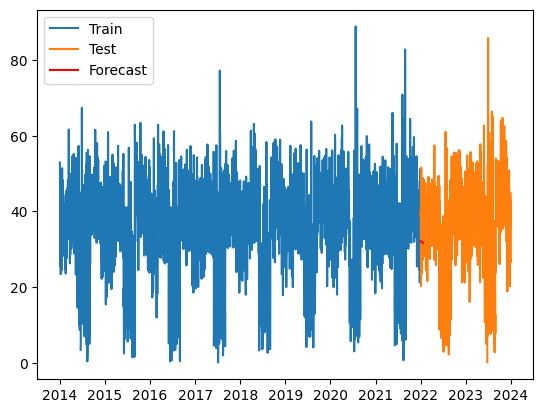

In [67]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

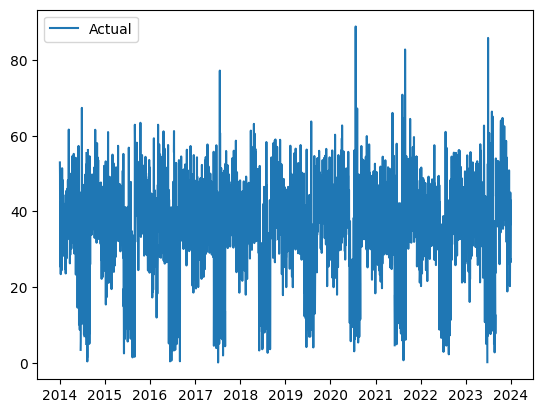

In [68]:
plt.plot(df['Crop_Yield'], label='Actual')
plt.legend()
plt.show()

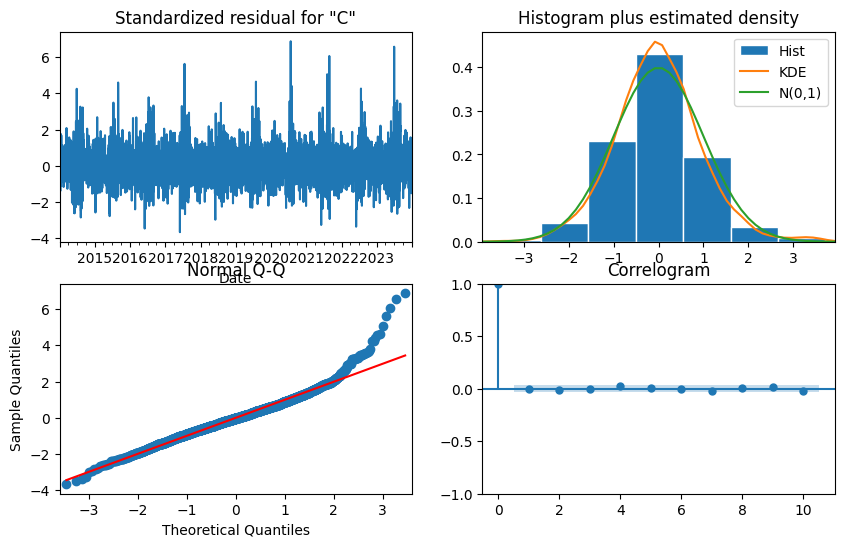

In [69]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Crop_Yield'], order=(1,1,1))
result = model.fit()
result.plot_diagnostics(figsize=(10,6))
plt.show()

**Prophpet**

In [70]:
from prophet import Prophet
df2=df.copy(deep=True)
df2=df2.reset_index()
df2

,Date,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,6.250000,17.832341,79.992489,7.649061,61.285714,50.142857,40.142857,52.962570,41.714286
1,2014-01-02,6.928571,17.403738,79.997477,9.731096,67.285714,54.500000,43.785714,49.481053,31.964286
2,2014-01-03,6.250000,17.710699,78.611669,12.161914,60.785714,49.571429,40.142857,31.582386,40.601190
3,2014-01-04,7.125000,17.068594,79.349411,9.476664,69.375000,56.000000,44.937500,35.247034,38.703125
4,2014-01-05,6.375000,15.439732,80.000000,10.793227,68.062500,54.562500,43.125000,32.578187,48.994792
...,...,...,...,...,...,...,...,...,...,...
3647,2023-12-27,6.406250,18.765488,79.418663,10.391741,63.687500,51.937500,41.125000,45.000561,27.786458
3648,2023-12-28,6.583333,15.818711,79.517023,11.417404,66.000000,54.166667,42.833333,36.566595,41.680556
3649,2023-12-29,6.843750,17.750068,79.094460,9.926405,66.062500,53.687500,42.375000,42.949637,39.281250
3650,2023-12-30,6.555556,15.174002,79.253593,8.844230,64.666667,51.944444,41.388889,26.585890,33.787037


In [71]:
df2=df2.rename(columns={"Date":'ds',"Crop_Yield":'y'})
df2

,ds,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,y,Soil_Quality
0,2014-01-01,6.250000,17.832341,79.992489,7.649061,61.285714,50.142857,40.142857,52.962570,41.714286
1,2014-01-02,6.928571,17.403738,79.997477,9.731096,67.285714,54.500000,43.785714,49.481053,31.964286
2,2014-01-03,6.250000,17.710699,78.611669,12.161914,60.785714,49.571429,40.142857,31.582386,40.601190
3,2014-01-04,7.125000,17.068594,79.349411,9.476664,69.375000,56.000000,44.937500,35.247034,38.703125
4,2014-01-05,6.375000,15.439732,80.000000,10.793227,68.062500,54.562500,43.125000,32.578187,48.994792
...,...,...,...,...,...,...,...,...,...,...
3647,2023-12-27,6.406250,18.765488,79.418663,10.391741,63.687500,51.937500,41.125000,45.000561,27.786458
3648,2023-12-28,6.583333,15.818711,79.517023,11.417404,66.000000,54.166667,42.833333,36.566595,41.680556
3649,2023-12-29,6.843750,17.750068,79.094460,9.926405,66.062500,53.687500,42.375000,42.949637,39.281250
3650,2023-12-30,6.555556,15.174002,79.253593,8.844230,64.666667,51.944444,41.388889,26.585890,33.787037


In [83]:
print(df2.columns)
print(df2.dtypes)
print(df2.head())


Index(['ds', 'Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K',
       'y', 'Soil_Quality'],
      dtype='object')
ds              datetime64[ns]
Soil_pH                float64
Temperature            float64
Humidity               float64
Wind_Speed             float64
N                      float64
P                      float64
K                      float64
y                      float64
Soil_Quality           float64
dtype: object
          ds   Soil_pH  Temperature   Humidity  Wind_Speed          N  \
0 2014-01-01  6.250000    17.832341  79.992489    7.649061  61.285714   
1 2014-01-02  6.928571    17.403738  79.997477    9.731096  67.285714   
2 2014-01-03  6.250000    17.710699  78.611669   12.161914  60.785714   
3 2014-01-04  7.125000    17.068594  79.349411    9.476664  69.375000   
4 2014-01-05  6.375000    15.439732  80.000000   10.793227  68.062500   

           P          K          y  Soil_Quality  
0  50.142857  40.142857  52.962570     41.714286  
1  5

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat  yhat_lower  yhat_upper
3672 2024-01-21  26.217404   18.705037   34.705658
3673 2024-01-22  26.104945   18.101530   33.100317
3674 2024-01-23  25.803787   18.492530   33.185013
3675 2024-01-24  26.326668   19.288173   33.931202
3676 2024-01-25  26.513096   19.304714   34.094698
3677 2024-01-26  26.275661   18.874332   33.845768
3678 2024-01-27  25.863244   18.069103   33.307834
3679 2024-01-28  26.359055   19.316649   34.007105
3680 2024-01-29  26.178849   18.692318   33.285483
3681 2024-01-30  25.805602   18.181315   33.639452


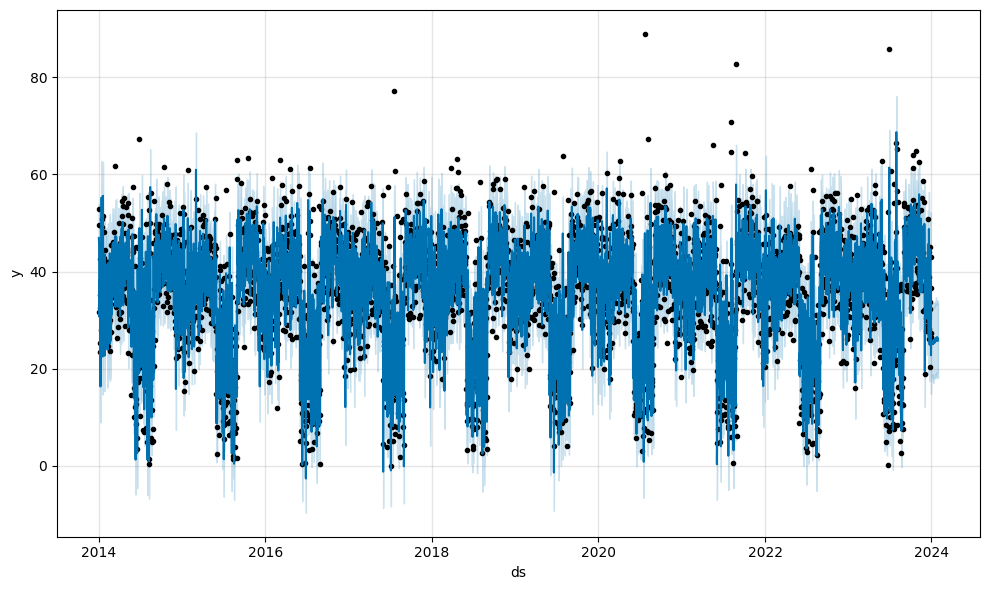

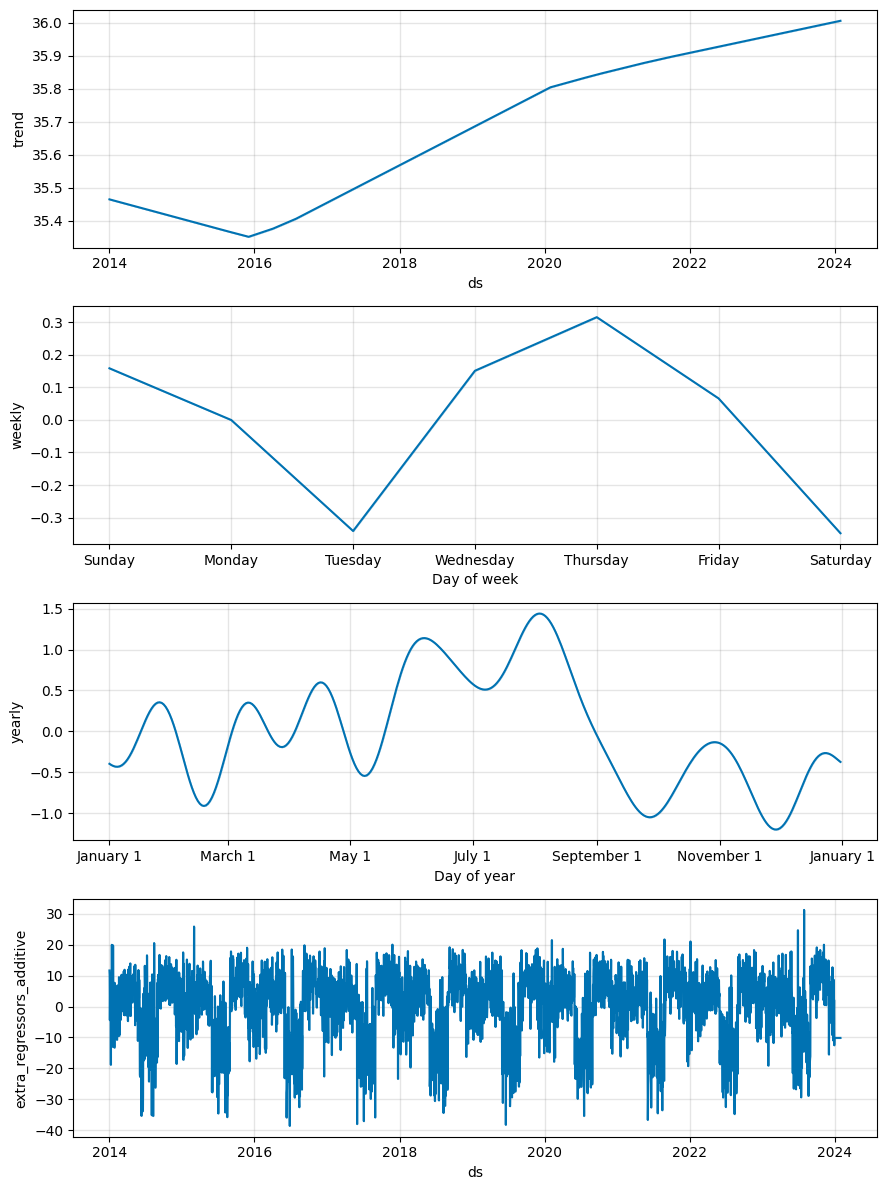

In [85]:
from prophet import Prophet

# 1. Initialize model
model = Prophet()

# 2. Add regressors (exclude ds and y)
regressors = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality']
for col in regressors:
    model.add_regressor(col)

# 3. Fit the model
model.fit(df2)

# 4. Create future dataframe
future = model.make_future_dataframe(periods=30, freq='D')

# 5. Merge regressors
future = future.merge(df2[['ds'] + regressors], on='ds', how='left')

# 6. Fill missing values for new future rows
future.ffill(inplace=True)
future.bfill(inplace=True)

# 7. Forecast
forecast = model.predict(future)

# 8. Plot results
model.plot(forecast)
model.plot_components(forecast)

# 9. Show predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))


In [95]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Take only the historical part that has actual y values
df_actual = df2[['ds','y']]
df_pred = forecast[['ds','yhat']]

# Merge actual and predicted
result = df_actual.merge(df_pred, on='ds')

# Calculate metrics
r2 = r2_score(result['y'], result['yhat'])
mae = mean_absolute_error(result['y'], result['yhat'])
rmse = np.sqrt(mean_squared_error(result['y'], result['yhat']))
mse = mean_squared_error(result['y'], result['yhat'])
mape = np.mean(np.abs((result['y'] - result['yhat']) / result['y'])) * 100

# Print results
print("📌 Model Performance Metrics")
print(f"R² Score : {r2:.4f}")
print(f"MAE     : {mae:.4f}")
print(f"MSE     : {mse:.4f}")
print(f"RMSE    : {rmse:.4f}")
print(f"MAPE    : {mape:.2f} %")


📌 Model Performance Metrics
R² Score : 0.7629
MAE     : 4.5029
MSE     : 34.6713
RMSE    : 5.8882
MAPE    : 25.58 %
